# Introdução

Jupter notebook destinado à elaboração de modelos de Machine Learning (ML) para análises preditivas de Taxas de Penetração (Rate of Penetration - ROP) em perfuração de poços de petróleo

### Datasets

Os datasets utilizados estão disponiveis em: https://www.mseel.com/data/Wells_Datasets/

Os arquivos especificos utilizados neste problema são:

* 3H_BottomHole1440325201Depth.las -> https://www.mseel.com/data/Wells_Datasets/MIP/MIP_3H/Drilling/. Download the Drilling MIP-3H.zip and open the Drilling 3H\mip3hdrillingrigdata\MIP3H_Drilling_Rig_Data\Pilot_Lateral folder and select the file BottomHole1440325201Depth.las

* 5H_Bottom1441631652Depth.las -> https://www.mseel.com/data/Wells_Datasets/MIP/MIP_5H/Drilling/ Download the Drilling_MIP_5H.zip and open the Drilling MIP-5H\mip5hdrillingrigdata\MIP5H_Drilling_Rig_Data\5H_Bottom_Hole folder and select the file 5H_Bottom1441631652Depth.las

* 5H_Top1435428151Depth.las -> https://www.mseel.com/data/Wells_Datasets/MIP/MIP_5H/Drilling/ Download the Drilling_MIP_5H.zip and open the Drilling MIP-5H\mip5hdrillingrigdata\MIP5H_Drilling_Rig_Data\5H_Top_Hole folder and select the file 5H_Top1435428151Depth.las

* SW1442084965Depth.las -> https://www.mseel.com/data/Wells_Datasets/MIP/MIP_SW/Drilling/ Download the Drilling_MIP_SW.zip  and open the Drilling MIP SW\mipswdrillingrigdata\MIP_SW_Drilling_Rig_Data folder and select SW1442084965Depth.las

Os 3 primeiros datasets serão concatenados e utilizados para as etapas de treino e teste dos modelos. O ultimo dataset será utilizado como dataset de validação dos modelos.

### Referências Gerais

* Kaggle - (GridSearchCV & Pipeline Applications) - https://www.kaggle.com/carlosdg/xgboost-with-scikit-learn-pipeline-gridsearchcv
* XGBoost - https://towardsdatascience.com/getting-started-with-xgboost-in-scikit-learn-f69f5f470a97

---
# Metodologia do Projeto

Inicialmente os datasets abaixo serão concatenados e seu resultado utilizados para treino e teste dos modelos preditivos de ML

* 3H_BottomHole1440325201Depth.las
* 5H_Bottom1441631652Depth.las
* 5H_Top1435428151Depth.las

Com os modelos já criados e treinados, o detaset abaixo será utilizado para validação dos modelos, que irão receber dados que não foram vistos durante as fazes de treino e teste (outside data)
* SW1442084965Depth.las

Python é a linguagem de programação utilizada e o scikit-learn (sklearn) será a biblioteca principal que permitirá a criação e implementação dos modelos de ML


---
# Projeto

## **STEP 1** - Carregando e concatenando os Dados. Salvando Dataframe (df)
Os datasets foram baixados e salvos localmente

#### Importando Bibliotecas e Pacotes

Algumas bibliotecas e/ou pacotes abaixo tiveram que ser instaladas. Segue abaixo referências para instalação:

* lasio - https://pypi.org/project/lasio/
* xgboost - https://pypi.org/project/xgboost/

In [3]:
# installing xgboost
!pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 173.6 MB 31.7 MB/s eta 0:00:01


In [2]:
# Bibliotecas básicas

import time
import numpy as np #version 1.20.1
import pandas as pd #version 1.2.4
import seaborn as sns #version 0.11.1
import lasio #version 0.29
import matplotlib.pyplot as plt #version 3.3.4
%matplotlib inline


# Jupyter Notebook Config.
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 30)


# Preprocess
from sklearn.impute import SimpleImputer # scikit-learn version 0.24.1
from sklearn.preprocessing import StandardScaler


# Pipeline
from sklearn.pipeline import make_pipeline


# Ajuste de configuração para permitir visualização do diagrama do pipeline
from sklearn import set_config
set_config(display='diagram')


# Train and test & params optimization
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


# ML Models
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor #xgboost version 1.5.1


# Instantiating ML Models and Preprocessors
imputer = SimpleImputer(strategy='mean')
scaler = StandardScaler()
knn = KNeighborsRegressor()
svm = SVR(kernel='rbf',gamma=1.5, C=5)
tree = DecisionTreeRegressor(random_state=1)
rforest = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
xtree_reg = ExtraTreesRegressor(n_estimators=10, random_state=1, n_jobs=-1)
xgb_reg = XGBRegressor(random_state=1, n_jobs=-1)

#### **Carregando os datasets**

In [3]:
# Carregando dados
mip3 = lasio.read("database/3H_BottomHole1440325201Depth.las").df()
mip5t = lasio.read("database/5H_Top1435428151Depth.las").df()
mip5b = lasio.read("database/5H_Bottom1441631652Depth.las").df()
sw = lasio.read("database/SW1442084965Depth.las").df()

# Verificando o shape de cada dataset
print('mip3 shape: ',mip3.shape)
print('mip5t shape: ',mip5t.shape)
print('mip5b shape: ',mip5b.shape)
print('sw shape: ', sw.shape)

mip3 shape:  (9091, 157)
mip5t shape:  (6465, 82)
mip5b shape:  (7999, 172)
sw shape:  (7553, 91)


#### **Descrição das Variáveis (Features Description)**
Sorted by curve column

In [4]:
features_description = pd.read_csv('database/features.csv', sep=':', index_col=False)
features = features_description.loc[: , ['curve','description']].sort_values(by='curve')
features

,curve,description
92,3GAS,3rdPartyGas
71,ADDRT,AutoDrillerDiffPressureResponseTunin
97,ADRRT,AutoDrillerROPResponseTuning
103,ADRSP,AutoDrillerOffBottomROPLimit
87,ADS,AutoDrillerStatus
...,...,...
95,WGASP,PercentWITSGAS
82,WIT4,NBINCCONT(DEG)
83,WIT6,NBAZICONT(DEG)
11,WOB,WeightonBit


#### **Concatenando os datasets**
* Dataset_1 - 3H_BottomHole1440325201Depth.las
* Dataset_2 - 5H_Bottom1441631652Depth.las
* Dataset_3 - 5H_Top1435428151Depth.las

O dataframe (df) resultante possue 185 colunas, mais do que os 3 datasets possuem individualmente, o que é um indicador de possíveis colunas com valores nulos, ou valores *missing*, ou ainda, como é comum e será mais utilizado nesse projeto, valor **NAN**.

In [5]:
# Concatenação 
df = pd.concat([mip3, mip5b, mip5t]).reset_index(drop=False)
print('df shape: ',df.shape)
df.head()

df shape:  (23555, 186)


,DEPT,ROP,BDEP,TC_3,TOP,HL,SPP,SPM1,SPM2,RPM,TOR,WOB,OBR,FLOW,MV,...,GV6,GV7,GV8,GV9,GV10,GV0,H2S,N2P,N2VI,HCF,N2VO,CONO,WIT1,WIT2,WIT3
0,1.0,0.32,1.0,94.0,187.35,43.6,0.0,0.0,0.0,0.0,0.033,111.6,0.32,3.0,75.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2.0,0.00,2.0,94.0,NaN,39.4,0.0,0.0,0.0,0.0,0.029,0.0,0.00,3.0,75.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,0.00,3.0,94.0,NaN,39.3,0.0,0.0,0.0,0.0,0.029,0.0,0.00,3.0,75.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,0.00,4.0,94.0,NaN,39.2,0.0,0.0,0.0,0.0,0.029,112.0,0.00,3.0,75.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,0.00,5.0,94.0,NaN,39.3,0.0,0.0,0.0,0.0,0.029,111.9,0.00,3.0,75.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Movendo coluna ROP para a primeira posição

first_column = df.pop('ROP')   
df.insert(0, 'ROP', first_column)

df.head()

,ROP,DEPT,BDEP,TC_3,TOP,HL,SPP,SPM1,SPM2,RPM,TOR,WOB,OBR,FLOW,MV,...,GV6,GV7,GV8,GV9,GV10,GV0,H2S,N2P,N2VI,HCF,N2VO,CONO,WIT1,WIT2,WIT3
0,0.32,1.0,1.0,94.0,187.35,43.6,0.0,0.0,0.0,0.0,0.033,111.6,0.32,3.0,75.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.00,2.0,2.0,94.0,NaN,39.4,0.0,0.0,0.0,0.0,0.029,0.0,0.00,3.0,75.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.00,3.0,3.0,94.0,NaN,39.3,0.0,0.0,0.0,0.0,0.029,0.0,0.00,3.0,75.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.00,4.0,4.0,94.0,NaN,39.2,0.0,0.0,0.0,0.0,0.029,112.0,0.00,3.0,75.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.00,5.0,5.0,94.0,NaN,39.3,0.0,0.0,0.0,0.0,0.029,111.9,0.00,3.0,75.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Adjustando 'sw' dataframe

In [7]:
# Movendo coluna ROP para a primeira posição

sw = sw.reset_index(drop=False)
first_column = sw.pop('ROP')
sw.insert(0, 'ROP', first_column)

print('sw shape: ',sw.shape)
sw.head()

sw shape:  (7553, 92)


,ROP,DEPT,BDEP,TOP,HL,SPP,MGLAL,RPM,TOR,WOB,OBR,MV,MVTT,LWEAR,TS1,...,DDPSP,TTWOB,MTWOB,ADTPD,P1RAT,P2RAT,TANKS,PMGL,PMGLT,T1ST,F1GLT,TTFIL,TTACC,DATE,TIME
0,0.22,41.0,41.0,267.21,113.9,109.0,0.0,42.0,5802.940,0.2,0.22,NaN,NaN,11212.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,150912.0,211049.0
1,1.41,42.0,42.0,42.55,6.7,110.0,0.0,17.0,263.134,0.5,1.41,NaN,NaN,11212.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,150912.0,211101.0
2,8.09,43.0,43.0,7.41,6.3,110.0,0.0,17.0,258.683,1.0,8.09,NaN,NaN,11212.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,150912.0,211118.0
3,41.88,44.0,44.0,1.43,6.0,110.0,0.0,17.0,258.683,1.1,41.88,NaN,NaN,11212.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,150912.0,211133.0
4,202.77,45.0,45.0,0.30,5.6,110.0,0.0,17.0,259.425,1.6,202.77,NaN,NaN,11212.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,150912.0,211156.0


Salvar o dataframe é importante para reduzir o tempo de processamento ao se trabalhar com scripts direto no Jupyter Notebook. 

In [8]:
# Salvando o dataframe resultante da concatenação em uma nova pasta chamada database2
df.to_csv('database2/df.csv', index=False, encoding='utf-8')
sw.to_csv('database2/sw.csv', index=False, encoding='utf-8')

---
## **STEP 2** - Data Cleaning

In [9]:
# Carrengado dataframes
df = pd.read_csv('database2/df.csv') # dataframe de treino e teste
sw = pd.read_csv('database2/sw.csv') # dataframe de verificação

In [10]:
df.head()

,ROP,DEPT,BDEP,TC_3,TOP,HL,SPP,SPM1,SPM2,RPM,TOR,WOB,OBR,FLOW,MV,...,GV6,GV7,GV8,GV9,GV10,GV0,H2S,N2P,N2VI,HCF,N2VO,CONO,WIT1,WIT2,WIT3
0,0.32,1.0,1.0,94.0,187.35,43.6,0.0,0.0,0.0,0.0,0.033,111.6,0.32,3.0,75.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.00,2.0,2.0,94.0,NaN,39.4,0.0,0.0,0.0,0.0,0.029,0.0,0.00,3.0,75.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.00,3.0,3.0,94.0,NaN,39.3,0.0,0.0,0.0,0.0,0.029,0.0,0.00,3.0,75.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.00,4.0,4.0,94.0,NaN,39.2,0.0,0.0,0.0,0.0,0.029,112.0,0.00,3.0,75.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.00,5.0,5.0,94.0,NaN,39.3,0.0,0.0,0.0,0.0,0.029,111.9,0.00,3.0,75.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
sw.head()

,ROP,DEPT,BDEP,TOP,HL,SPP,MGLAL,RPM,TOR,WOB,OBR,MV,MVTT,LWEAR,TS1,...,DDPSP,TTWOB,MTWOB,ADTPD,P1RAT,P2RAT,TANKS,PMGL,PMGLT,T1ST,F1GLT,TTFIL,TTACC,DATE,TIME
0,0.22,41.0,41.0,267.21,113.9,109.0,0.0,42.0,5802.940,0.2,0.22,NaN,NaN,11212.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,150912.0,211049.0
1,1.41,42.0,42.0,42.55,6.7,110.0,0.0,17.0,263.134,0.5,1.41,NaN,NaN,11212.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,150912.0,211101.0
2,8.09,43.0,43.0,7.41,6.3,110.0,0.0,17.0,258.683,1.0,8.09,NaN,NaN,11212.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,150912.0,211118.0
3,41.88,44.0,44.0,1.43,6.0,110.0,0.0,17.0,258.683,1.1,41.88,NaN,NaN,11212.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,150912.0,211133.0
4,202.77,45.0,45.0,0.30,5.6,110.0,0.0,17.0,259.425,1.6,202.77,NaN,NaN,11212.0,0.0,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,150912.0,211156.0


### Filtrando "df" para conter apenas colunas que existem em "sw"

In [12]:
df = df[sw.keys()]
print('df shape: ',df.shape)

df shape:  (23555, 92)


In [13]:
df.head()

,ROP,DEPT,BDEP,TOP,HL,SPP,MGLAL,RPM,TOR,WOB,OBR,MV,MVTT,LWEAR,TS1,...,DDPSP,TTWOB,MTWOB,ADTPD,P1RAT,P2RAT,TANKS,PMGL,PMGLT,T1ST,F1GLT,TTFIL,TTACC,DATE,TIME
0,0.32,1.0,1.0,187.35,43.6,0.0,128.0,0.0,0.033,111.6,0.32,75.2,0.0,1327.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,255.0,-37.8,100.0,16.0,14.0,0.0,0.0,150828.0,151140.0
1,0.00,2.0,2.0,NaN,39.4,0.0,128.0,0.0,0.029,0.0,0.00,75.2,0.0,1327.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,255.0,-37.8,100.0,16.0,14.0,0.0,0.0,150828.0,151142.0
2,0.00,3.0,3.0,NaN,39.3,0.0,128.0,0.0,0.029,0.0,0.00,75.2,0.0,1327.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,255.0,-37.8,100.0,16.0,14.0,0.0,0.0,150828.0,151143.0
3,0.00,4.0,4.0,NaN,39.2,0.0,128.0,0.0,0.029,112.0,0.00,75.2,0.0,1327.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,255.0,-37.8,100.0,16.0,14.0,0.0,0.0,150828.0,151144.0
4,0.00,5.0,5.0,NaN,39.3,0.0,128.0,0.0,0.029,111.9,0.00,75.2,0.0,1327.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,255.0,-37.8,100.0,16.0,14.0,0.0,0.0,150828.0,151146.0


#### **Valores NANs**

In [14]:
# Total de valores NANs
print('Total de valores NAN em todo DataFrame: ', df.isna() .sum().sum(), "\n")
#print(df.isna().sum(), '\n')
df.isna().sum()

Total de valores NAN em todo DataFrame:  388061 



ROP         0
DEPT        0
BDEP        0
TOP        30
HL          0
         ... 
F1GLT       0
TTFIL    6465
TTACC    6465
DATE        0
TIME        0
Length: 92, dtype: int64

Para este projeto serão removidas as colunas com mais de 25% dos seus valores NAN. 25% representa, aproximadamente, o total de columnas do menor dataset utilizado durante a etapa de concatenação e por tanto, para garantir que ao menos um dataset nao tenha contribuido integralmente com alguma coluna com valores apenas NANs, utilizaremos 25% como forma de excluir essa possibilidade.

#### **Criando uma função para remoção de colunas com mais de 25% de valores NAN**

In [15]:
# Função que cria novo Dataframe excluindo as colunas onde mais de 25% de valores são NANs
def remove_nan_columns(df):
    return df[df.columns[df.isna().mean() < 0.25]]

df_filtered = remove_nan_columns(df)

In [16]:
print('dataframe original (df): ', df.shape,'colunas')
print('dataframe filtrado (df_filtered): ',df_filtered.shape,'colunas')

dataframe original (df):  (23555, 92) colunas
dataframe filtrado (df_filtered):  (23555, 60) colunas


In [17]:
print(df_filtered.columns)

Index(['ROP', 'DEPT', 'BDEP', 'TOP', 'HL', 'SPP', 'MGLAL', 'RPM', 'TOR', 'WOB',
       'OBR', 'LWEAR', 'TS1', 'TS2', 'TPO', 'BHT', 'TS3', 'OBH', 'CIRH',
       'INCL', 'AZ', 'TGR', 'OVRP', 'FSTK', 'MPRS', 'MHKL', 'MTOR', 'MRPM',
       'MWOB', 'DYNIN', 'DYNAZ', 'SKTTL', 'BR', 'TT1LO', 'TT1HI', 'TT2LO',
       'TT2HI', 'SNDEP', 'DIFP', 'DTDSP', 'DRACT', 'ADRSP', 'TRSP', 'TS4',
       'TS1-4', 'ADS', 'ADSE', 'CTOR', 'MCTOR', 'MTRPM', 'WOBSP', 'DDPSP',
       'TTWOB', 'MTWOB', 'P1RAT', 'P2RAT', 'PMGLT', 'F1GLT', 'DATE', 'TIME'],
      dtype='object')


In [18]:
print("total valores NAN's dataframe original (df): ", df.isna().sum().sum())
print("total valores NAN's dataframe filtrado (df_filtered): ", df_filtered.isna().sum().sum())

total valores NAN's dataframe original (df):  388061
total valores NAN's dataframe filtrado (df_filtered):  396


Observa-se que ainda existem valores NAN's no dataframe filtrado. Esses valores serão tratados posteriormente durante a etapa de execusão de uma Pipeline (processo que permite integrar diversas etapadas de preprocessamento e treinamento de modelos).

## STEP 3 -  **Feature Selection**

Alguns testes foram feitos previamente mesmo após a filtragem dos dados e remoção das colunas com valores predominantemente NAN's, observou-se que o tempo de treinamento de alguns modelos ainda era relativamente extenso dada a quantidade de dados e a limitação computacional disponivel para este projeto. Um processo de Feature Selection será aplicado a fim de identificar as variáveis mais relevantes para o futuro treinamento dos modelos. 


Entretanto, a metodologia que será adotada para a identificação das melhores "features" irá antecipar, em grande parte, o processo basico do treinamento de modelos, uma vez que utilizaremos alguns algoritimos de ML para identificar essas melhores variáveis. Além disso, serão utilizados dois outros critérios que serão: a compreensão do negócio e a medição da correlação entre as variáveis. O objetivo final é obter um range de até 15 variáveis que sejam parte das variáveis mais relevantes para o treinamento dos modelos ao mesmo tempo que são significativas para o problema de negócio permitindo assim que seja um modelo generalista, replicável e compatível com a realidade da companhia e em especial com a operação de perfuração de poços de petróleo:

### Metodologia de "feature selection"

* Treinamento de modelo(s) de ML que permita a identificação das 25 melhores variáveis;
* Eliminar as variáveis que são pouco significativa ao modelo de negócio e manter as variáveis com maior representatividade e replicabilidade para aplicaçãoes em estudos de perfuração de poços futuro;
* Avaliação das variáveis e como estas estão correlacionadas entre si e em relação à variável target.

In [19]:
# definindo X, y & new_X (filtrado NANs (25%) e removido colunas irrelevantes para a analise)
X = df.iloc[ : , 1: ]
new_X = df_filtered.iloc[ : , 1: ].drop((['OBR','DATE','TIME']), axis=1)
y = df['ROP']

print('shape de X: ', X.shape)
print('shape de new_X: ', new_X.shape)
print('shape de y: ', y.shape)

shape de X:  (23555, 91)
shape de new_X:  (23555, 56)
shape de y:  (23555,)


In [20]:
# Reviewing total of NAN's
df_filtered.isna().sum().sum()

396

### Best Features

Criando pipeline para tratar valores NAN's, padronizar os dados aplicando a função StandardScaler e em seguida treinar dois modelo (ExtraTreeRegressor e XGBoost Regressor) para obter as melhores variáveis a partir de uma função desses modelos chamada de **feature importance**.

#### ExtraTreeRegressor (xtree_reg)

In [21]:
#pipeline
xtree_pipe = make_pipeline(imputer, scaler, xtree_reg)
xtree_pipe.fit(new_X,y)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('extratreesregressor',
                 ExtraTreesRegressor(n_estimators=10, n_jobs=-1,
                                     random_state=1))])

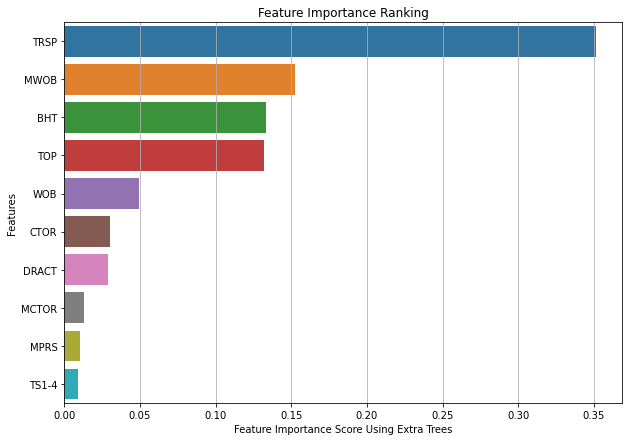

In [22]:
# Extra Trees - feature importance das 10 variáveis mais relevantes
plt.figure(figsize=(10,7))
xtree_feature_imp = pd.Series(xtree_reg.feature_importances_, 
                              index=new_X.columns).sort_values(ascending=False).nlargest(10)
sns.barplot(x=xtree_feature_imp, y=xtree_feature_imp.index)
plt.xlabel('Feature Importance Score Using Extra Trees')
plt.ylabel('Features')
plt.title('Feature Importance Ranking')
plt.grid(axis='x')
plt.show()

#### XGBoost Regressor (xgb_reg)

In [23]:
xgb_pipe = make_pipeline(imputer, scaler, xgb_reg)
xgb_pipe.fit(new_X,y)

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler()),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=-1, num_parallel_tree=1, random_state=1,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, tree_method='exact',
                              validate_parameters=1, verbosity=None))])

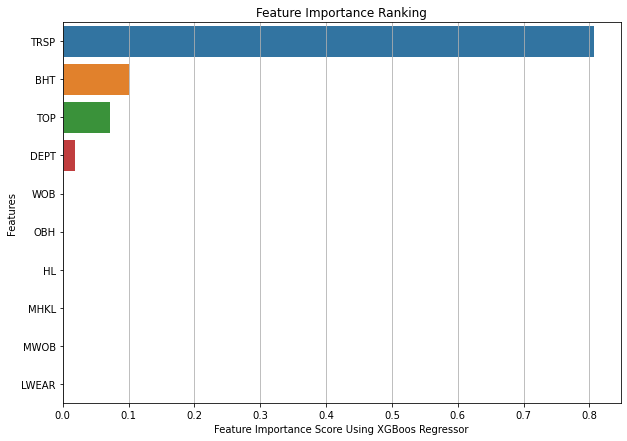

In [24]:
# XGBoost - feature importance das 10 variáveis mais relevantes
plt.figure(figsize=(10,7))
xgb_feature_imp = pd.Series(xgb_reg.feature_importances_,
                            index=new_X.columns).sort_values(ascending=False).nlargest(10)
sns.barplot(x=xgb_feature_imp, y=xgb_feature_imp.index)
plt.xlabel('Feature Importance Score Using XGBoos Regressor')
plt.ylabel('Features')
plt.title('Feature Importance Ranking')
plt.grid(axis='x')
plt.show()

In [25]:
#concatenação das variáveis mais importantes com base no modelos de XGBoost e Extra Tree Regressor
feature_imp = sorted(list(set(xtree_feature_imp.index) | set(xgb_feature_imp.index)))
feature_imp.append('ROP')
print(feature_imp)

['BHT', 'CTOR', 'DEPT', 'DRACT', 'HL', 'LWEAR', 'MCTOR', 'MHKL', 'MPRS', 'MWOB', 'OBH', 'TOP', 'TRSP', 'TS1-4', 'WOB', 'ROP']


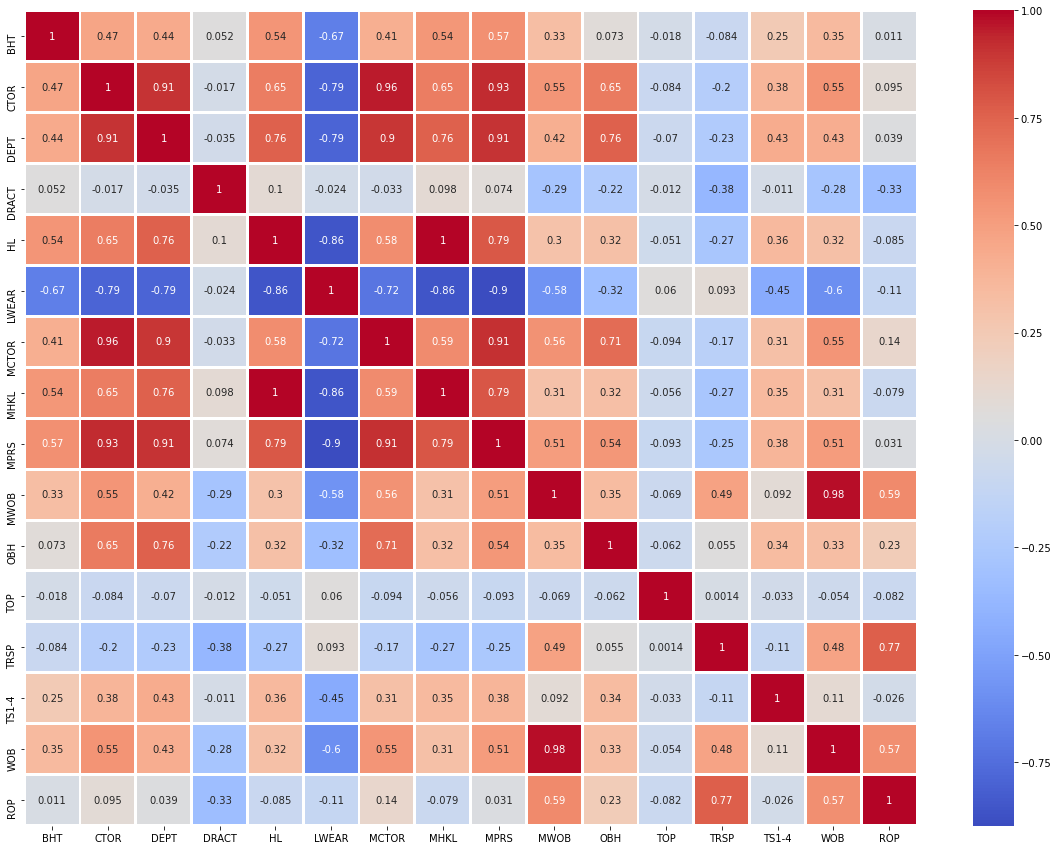

In [26]:
# Heatmap

from IPython.display import Image
import seaborn as sns
import matplotlib.pyplot as plt 

plt.figure(figsize=(20,15))
sns_heatmap = sns.heatmap(df_filtered[feature_imp].corr(), annot=True, linecolor='white', linewidths=2, cmap='coolwarm')
plt.savefig("heatmap.png")

In [27]:
# Excluindo features com baixa interpretabilidade e/ou replicabilidade e representatividade para o problema de negócio
best_features = [i for i in feature_imp if i not in ('WOB','DRACT','MHKL','LWEAR','CTOR')]
print('total de "feature": ', len(best_features))
print(best_features)

total de "feature":  11
['BHT', 'DEPT', 'HL', 'MCTOR', 'MPRS', 'MWOB', 'OBH', 'TOP', 'TRSP', 'TS1-4', 'ROP']


Foi incluida a variável target **ROP** para observar a relação com as variáveis preditoras

In [28]:
# shape
df_filtered[best_features].shape

(23555, 11)

In [29]:
# NANs
df_filtered[best_features].isna().sum().sum()

30

In [30]:
# Dataframe contendo somente as variáveis finais (best features) selecionadas
df_cleaned = df_filtered.copy()[best_features]
df_cleaned.head()

,BHT,DEPT,HL,MCTOR,MPRS,MWOB,OBH,TOP,TRSP,TS1-4,ROP
0,99.1,1.0,43.6,0.0,0.0,0.0,52.7,187.35,50.44,1.0,0.32
1,74.1,2.0,39.4,0.0,0.0,0.0,52.7,NaN,51.24,1.0,0.00
2,72.5,3.0,39.3,0.0,0.0,0.0,52.7,NaN,50.44,1.0,0.00
3,71.3,4.0,39.2,0.0,0.0,0.0,52.7,NaN,50.44,1.0,0.00
4,70.3,5.0,39.3,0.0,0.0,0.0,52.7,NaN,51.24,1.0,0.00


In [31]:
df_cleaned.keys()

Index(['BHT', 'DEPT', 'HL', 'MCTOR', 'MPRS', 'MWOB', 'OBH', 'TOP', 'TRSP',
       'TS1-4', 'ROP'],
      dtype='object')

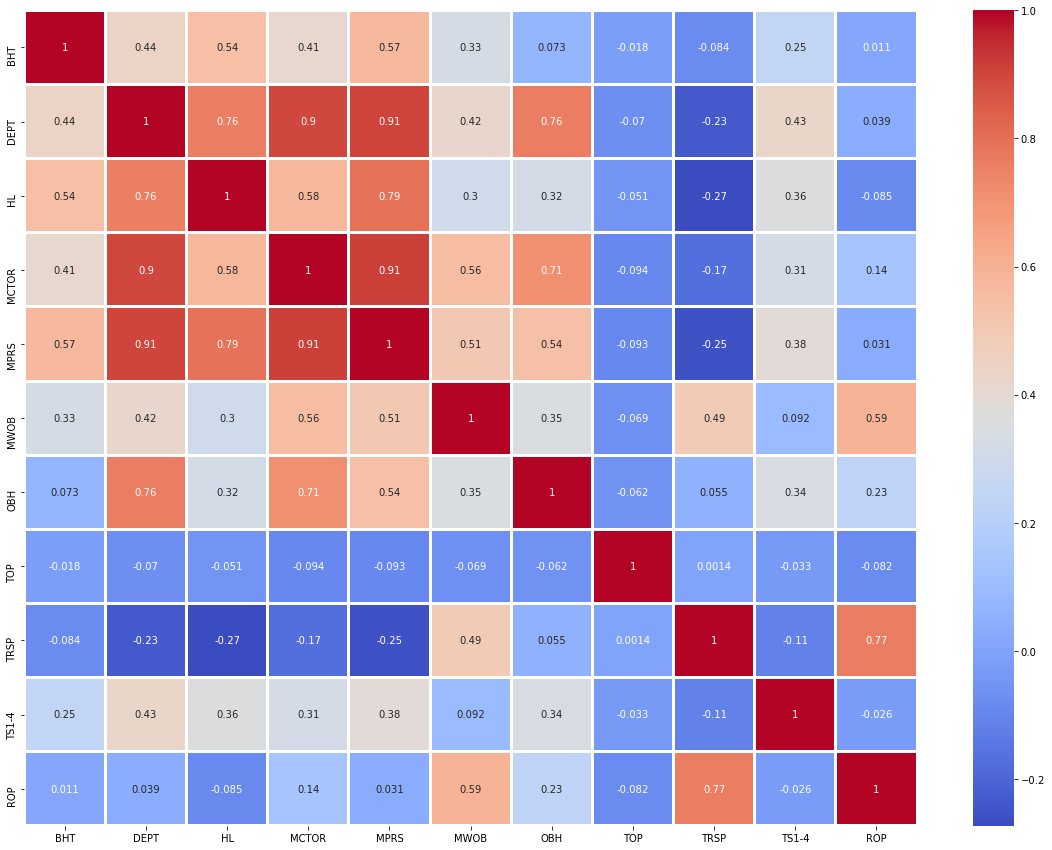

In [32]:
# Heatmap (Best Features)
from IPython.display import Image
import seaborn as sns
import matplotlib.pyplot as plt 

plt.figure(figsize=(20,15))
sns_heatmap = sns.heatmap(df_cleaned.corr(), annot=True, linecolor='white', linewidths=2,
                          cmap='coolwarm')
plt.savefig("heatmap.png")

In [33]:
# Estatisticas básicas
df_cleaned.describe()

,BHT,DEPT,HL,MCTOR,MPRS,MWOB,OBH,TOP,TRSP,TS1-4,ROP
count,23555.000000,23555.000000,23555.000000,23555.000000,23555.000000,23555.000000,23555.000000,23525.000000,23555.000000,23555.000000,23555.00000
mean,66.222267,8099.562726,109.801104,9.134239,2396.341541,16.093331,36.604615,0.896962,4.979629,110175.525918,156.47346
std,34.042178,3810.742395,35.558038,6.505279,1320.618784,13.026927,19.667710,6.127114,11.780006,172030.880329,188.34213
min,0.000000,1.000000,3.400000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000,0.00000
25%,40.600000,5733.500000,92.600000,2.000000,543.000000,4.500000,20.800000,0.300000,2.400000,0.000000,84.12000
50%,62.900000,8294.000000,123.800000,9.000000,2907.000000,16.100000,38.300000,0.390000,4.000000,19958.000000,154.18000
75%,94.650000,11232.000000,131.200000,15.000000,3475.000000,24.500000,52.200000,0.710000,4.330000,131838.000000,200.61000
max,141.100000,14454.000000,173.600000,22.000000,4128.000000,110.200000,75.700000,569.760000,200.970000,590032.000000,5688.85000


#### Redefinindo "sw" baseado nas melhores features 

In [34]:
# Ajustando blind dataset
sw_cleaned = sw[df_cleaned.keys()]
sw_cleaned.head()

,BHT,DEPT,HL,MCTOR,MPRS,MWOB,OBH,TOP,TRSP,TS1-4,ROP
0,47.7,41.0,113.9,0.0,0.0,0.0,2.7,267.21,8.66,0.0,0.22
1,32.5,42.0,6.7,0.0,109.0,0.1,2.7,42.55,8.66,0.0,1.41
2,31.4,43.0,6.3,0.0,109.0,0.5,2.7,7.41,8.66,0.0,8.09
3,30.4,44.0,6.0,0.0,109.0,0.8,2.7,1.43,4.33,0.0,41.88
4,29.4,45.0,5.6,0.0,109.0,1.1,2.7,0.30,4.33,0.0,202.77


In [35]:
# Estatisticas básicas blind dataset
sw_cleaned.describe()

,BHT,DEPT,HL,MCTOR,MPRS,MWOB,OBH,TOP,TRSP,TS1-4,ROP
count,7553.000000,7553.000000,7553.000000,7553.000000,7553.000000,7553.000000,7553.000000,7551.000000,7553.000000,7553.0,7553.000000
mean,21.900000,3854.047134,53.121038,2.959089,363.315371,2.212896,13.587819,0.531858,6.830062,0.0,195.760459
std,10.189691,2204.094281,24.386298,1.458753,66.985014,1.205046,9.650101,5.448288,2.215320,0.0,66.502382
min,0.700000,41.000000,3.300000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.0,0.000000
25%,14.100000,1945.000000,32.200000,2.000000,334.000000,1.600000,5.400000,0.250000,4.330000,0.0,148.970000
50%,21.900000,3853.000000,49.200000,3.000000,373.000000,2.100000,10.900000,0.310000,8.660000,0.0,195.260000
75%,29.700000,5762.000000,74.900000,4.000000,398.000000,2.700000,22.300000,0.400000,8.660000,0.0,238.190000
max,49.600000,7671.000000,120.800000,6.000000,718.000000,7.100000,33.800000,327.210000,47.600000,0.0,631.490000


### Outliers
Observação de outliers sob as variáveis escolhidas ao final do processo de seleção

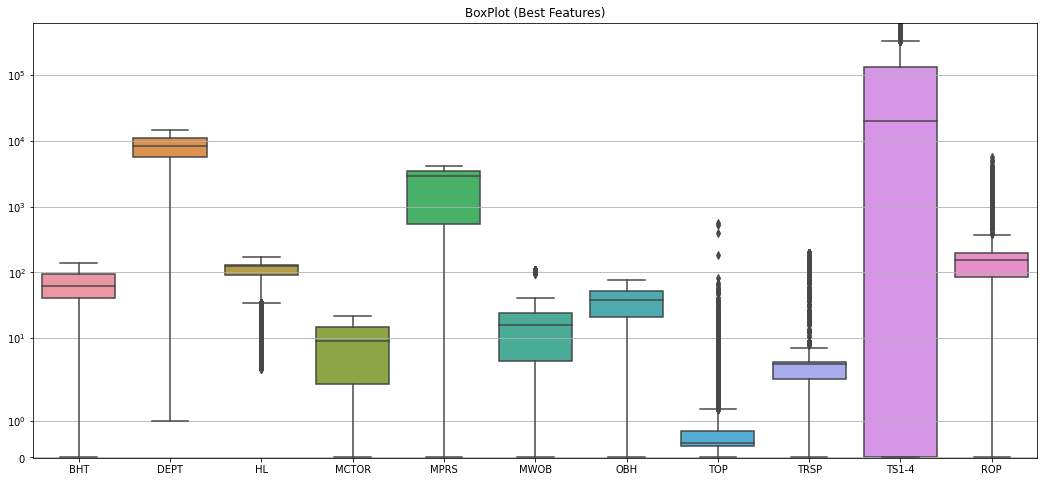

In [36]:
plt.figure(figsize=(18,8))
sns.boxplot(x=None, y=None, data=df_cleaned, orient='v')
plt.yscale('symlog')
plt.ylim(-0.01)
plt.title("BoxPlot (Best Features)")
plt.grid(axis='y')
plt.show()

### Definindo novos valores para "X" (Cleaned_X)

In [37]:
# definindo cleaned_X, y
cleaned_X = df_cleaned.copy().iloc[ : , :-1]

print('shape de df_cleaned: ', df_cleaned.shape)
print('shape de cleaned_X: ', cleaned_X.shape)
print('shape de cleaned_y: ', y.shape)

shape de df_cleaned:  (23555, 11)
shape de cleaned_X:  (23555, 10)
shape de cleaned_y:  (23555,)


In [38]:
cleaned_X.head()

,BHT,DEPT,HL,MCTOR,MPRS,MWOB,OBH,TOP,TRSP,TS1-4
0,99.1,1.0,43.6,0.0,0.0,0.0,52.7,187.35,50.44,1.0
1,74.1,2.0,39.4,0.0,0.0,0.0,52.7,NaN,51.24,1.0
2,72.5,3.0,39.3,0.0,0.0,0.0,52.7,NaN,50.44,1.0
3,71.3,4.0,39.2,0.0,0.0,0.0,52.7,NaN,50.44,1.0
4,70.3,5.0,39.3,0.0,0.0,0.0,52.7,NaN,51.24,1.0


In [39]:
# Variável Target (ROP)
y

0          0.32
1          0.00
2          0.00
3          0.00
4          0.00
          ...  
23550    161.87
23551    168.82
23552    174.19
23553    179.49
23554    183.04
Name: ROP, Length: 23555, dtype: float64

## Separado dados em treino e teste

In [40]:
# Splitting dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(cleaned_X, y,test_size=0.30)

In [41]:
# Shape dos dados de treino e teste
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((16488, 10), (7067, 10), (16488,), (7067,))

## Cross-Validation (Construindo as Pipelines e treinando os modelos)

#### KNN

In [42]:
# pipeline using X_train,y_train (KNN)
start = time.time()

knn_pipe = make_pipeline(imputer, scaler, knn)
knn_pipe.fit(X_train,y_train)

stop = time.time()
print('pipeline run time: ',round((stop - start),2),'sec')


# Cross Validation on df_cleaned data
start = time.time()

print('cross_val_score: ',round(cross_val_score(knn_pipe, cleaned_X, y, cv=15, scoring='r2').mean(), 4))

stop = time.time()
print('cross_val run time: ',round((stop - start),2),'sec')

pipeline run time:  0.06 sec
cross_val_score:  0.3888
cross_val run time:  2.86 sec


#### ExtraTreeRegressor

In [43]:
# pipeline using X_train,y_train (ExtraTreeRegressor)
start = time.time()

xtree_pipe = make_pipeline(imputer, scaler, xtree_reg)
xtree_pipe.fit(X_train,y_train)

stop = time.time()
print('pipeline run time: ',round((stop - start),2),'sec')


# Cross Validation on df_cleaned data
start = time.time()

print('cross_val_score: ',round(cross_val_score(xtree_pipe, cleaned_X, y, cv=15, scoring='r2').mean(), 4))

stop = time.time()
print('cross_val run time: ',round((stop - start),2),'sec')

pipeline run time:  0.12 sec
cross_val_score:  0.8857
cross_val run time:  4.8 sec


#### XGBoost

In [44]:
# pipeline using X_train,y_train (XGBoost) (com outlier)
start = time.time()

xgb_pipe = make_pipeline(imputer, scaler, xgb_reg)
xgb_pipe.fit(X_train,y_train)

stop = time.time()
print('pipeline run time: ',round((stop - start),2),'sec')


# Cross Validation on df_cleaned data
start = time.time()

print('cross_val_score: ',round(cross_val_score(xgb_pipe, cleaned_X, y, cv=15, scoring='r2').mean(), 4))

stop = time.time()
print('cross_val run time: ',round((stop - start),2),'sec')

pipeline run time:  1.72 sec
cross_val_score:  0.936
cross_val run time:  32.44 sec


## Otimização de Parametros com GridSearchCV

## KNN

In [45]:
# Parametros do modelo knn
knn.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

**KNN - Otimização do modelo**

In [46]:
# parametros para otmização
params = {}
params['simpleimputer__strategy'] = ['mean','median']
params['kneighborsregressor__n_neighbors'] = range(3,15)
params['kneighborsregressor__weights'] = ['uniform','distance']
params['kneighborsregressor__leaf_size'] = range(10,30)

# GridSearchCV on df_cleaned data
start = time.time()

knn_pipe = make_pipeline(imputer, scaler, knn)
knn_grid = GridSearchCV(knn_pipe, params, cv=15, scoring='r2', n_jobs=-1)
knn_grid.fit(X_train,y_train)

stop = time.time()
print('knn_grid run time: ',round((stop - start),2),'sec')
print('knn_grid best score: ', round(knn_grid.best_score_, 4))
print('knn_grid best params: ', knn_grid.best_params_)

knn_grid run time:  288.97 sec
knn_grid best score:  0.8997
knn_grid best params:  {'kneighborsregressor__leaf_size': 10, 'kneighborsregressor__n_neighbors': 6, 'kneighborsregressor__weights': 'distance', 'simpleimputer__strategy': 'median'}


**KNN - Predição com dados de teste (knn_r2)**

In [67]:
# predição com dados de teste
y_pred = knn_grid.predict(X_test)

# r2 y_test & y_predicted
knn_r2 = np.corrcoef(y_test,y_pred)[0,1]
print('knn_r2:', round(knn_r2, 3))

knn_r2: 0.96


**KNN - Predição com dados do blind dataset (knn_R2)**

In [68]:
# blind dataset
sw_cleaned.head()

y_blind = sw_cleaned['ROP']
x_blind = sw_cleaned.drop(['ROP'], axis=1)

In [69]:
# predição com dados do blind dataset
y_pred_blind = knn_grid.predict(x_blind)

knn_R2 = np.corrcoef(y_blind,y_pred_blind)[0,1]
print('knn_R2:',round(knn_R2,3))

knn_R2: 0.314


**KNN - Scater plot (blind dataset)**

ROP real vs. ROP predição

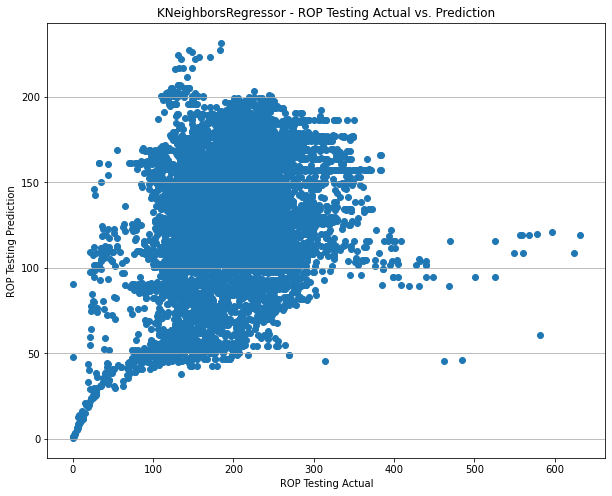

In [70]:
# Scaterplot ROP Testing Actual (y_blind) vs. Prediction (y_pred_blind)

plt.figure(figsize=(10,8))
plt.scatter(y_blind, y_pred_blind)
plt.xlabel('ROP Testing Actual')
plt.ylabel('ROP Testing Prediction')
plt.title('KNeighborsRegressor - ROP Testing Actual vs. Prediction')
plt.grid(axis='y')
plt.show()

**KNN - Grafico de ROP (blind dataset)**

ROP Real (azul) vs. ROP predição (verde)

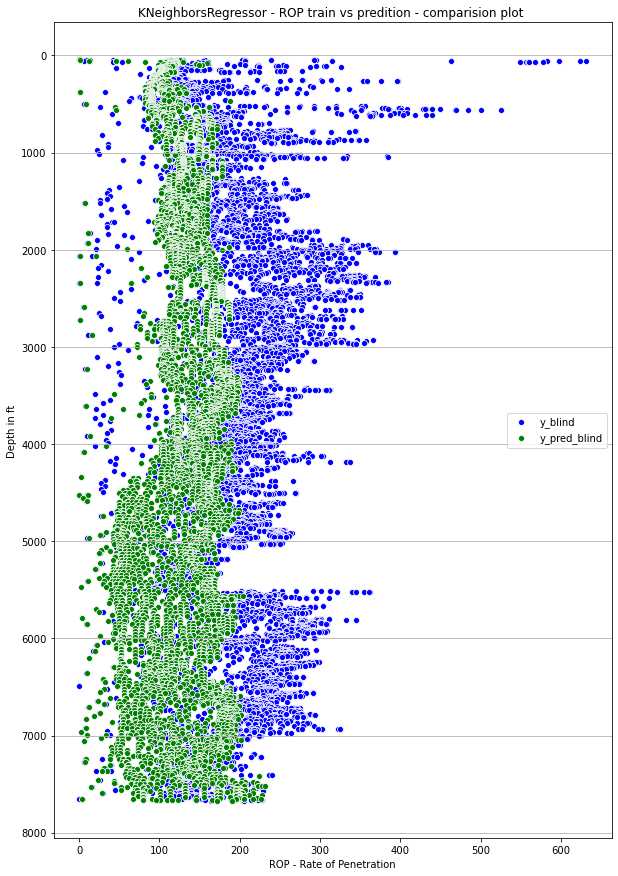

In [86]:
# ROP Blind vs. Preiction - Comparação

plt.figure(figsize=(10,15))
sns.scatterplot(x=y_blind, y=sw_cleaned['DEPT'], label='y_blind', color='blue')
sns.scatterplot(x=y_pred_blind, y=sw_cleaned['DEPT'], label='y_pred_blind', color='green')
#plt.xscale('log')
#plt.xscale('symlog')
plt.grid(axis='y')
plt.xlabel('ROP - Rate of Penetration')
plt.ylabel('Depth in ft')
plt.title('KNeighborsRegressor - ROP train vs predition - comparision plot ')
plt.gca().invert_yaxis()
plt.legend(loc=7)
plt.show()

## ExtraTreeRegression

In [99]:
# Parametros do modelo Extra Tree Regressor
xtree_reg.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

**ExtraTrees - Otimização do modelo**

In [100]:
# parametros para otmização
params = {}
params['simpleimputer__strategy'] = ['mean','median']
params['extratreesregressor__n_estimators'] = range(3,15)

# GridSearchCV on df_cleaned data
start = time.time()

xtree_pipe = make_pipeline(imputer, scaler, xtree_reg)
xtree_grid = GridSearchCV(xtree_pipe, params, cv=15, scoring='r2', n_jobs=-1)
xtree_grid.fit(X_train,y_train)

stop = time.time()
print('xtree_grid run time: ',round((stop - start),2),'sec')
print('xtree_grid best score: ', round(xtree_grid.best_score_, 4))
print('xtree_grid best params: ', xtree_grid.best_params_)

xtree_grid run time:  29.99 sec
xtree_grid best score:  0.9798
xtree_grid best params:  {'extratreesregressor__n_estimators': 9, 'simpleimputer__strategy': 'median'}


**ExtraTrees - Predição com dados de teste (xtree_r2)**

In [101]:
# predição com dados de teste
y_pred = xtree_grid.predict(X_test)

# r2 y_test & y_predicted
xtree_r2 = np.corrcoef(y_test,y_pred)[0,1]
print('xtree_r2:', round(xtree_r2, 3))

xtree_r2: 0.988


**ExtraTrees - Predição com dados do blind dateset (xtree_R2)**

In [102]:
# blind dataset
sw_cleaned.head()

y_blind = sw_cleaned['ROP']
x_blind = sw_cleaned.drop(['ROP'], axis=1)

In [103]:
# predição com dados do blind dataset
y_pred_blind = xtree_grid.predict(x_blind)

xtree_R2 = np.corrcoef(y_blind,y_pred_blind)[0,1]
print('xtree_R2:',round(xtree_R2,3))

xtree_R2: 0.587


**ExtraTrees - Scater plot (blind dataset)**

ROP real vs. ROP predição

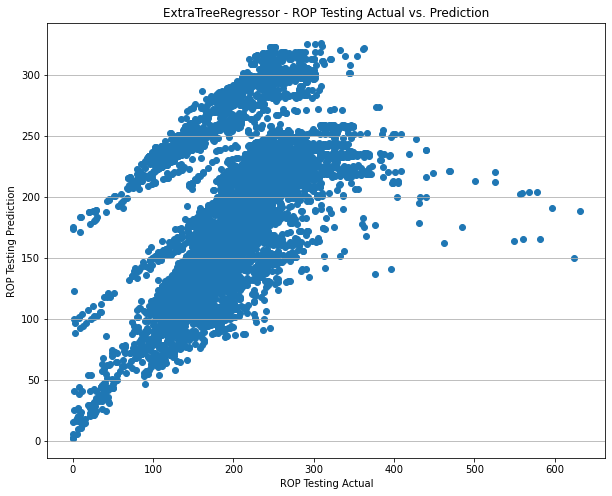

In [104]:
# Scaterplot ROP Testing Actual (y_blind) vs. Prediction (y_pred_blind)

plt.figure(figsize=(10,8))
plt.scatter(y_blind, y_pred_blind)
plt.xlabel('ROP Testing Actual')
plt.ylabel('ROP Testing Prediction')
plt.title('ExtraTreeRegressor - ROP Testing Actual vs. Prediction')
plt.grid(axis='y')
plt.show()

**ExtraTrees - Grafico de ROP (blind dataset)**

ROP Real (azul) vs. ROP predição (verde)

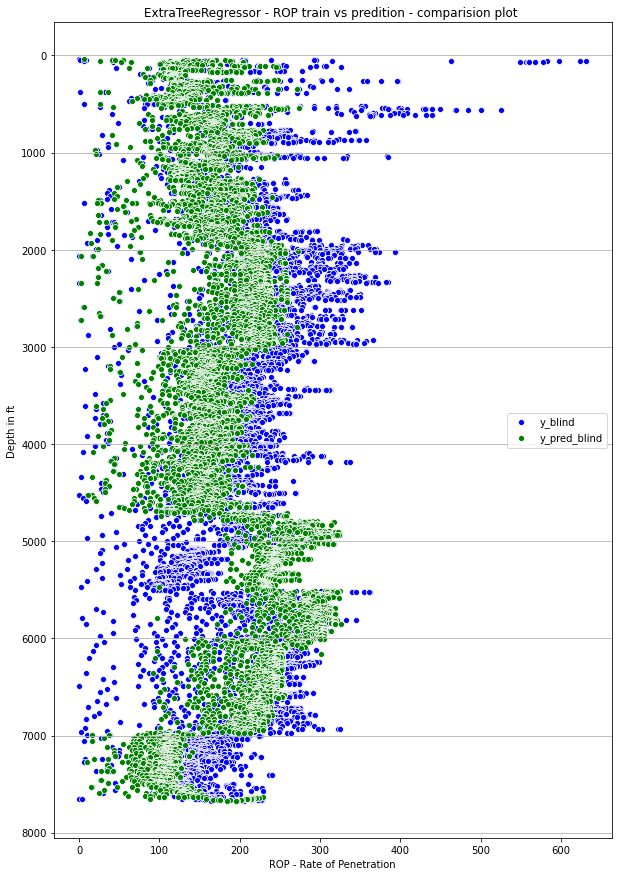

In [105]:
# ROP Blind vs. Preiction - Comparação

plt.figure(figsize=(10,15))
sns.scatterplot(x=y_blind, y=sw_cleaned['DEPT'], label='y_blind', color='blue')
sns.scatterplot(x=y_pred_blind, y=sw_cleaned['DEPT'], label='y_pred_blind', color='green')
#plt.xscale('log')
#plt.xscale('symlog')
plt.grid(axis='y')
plt.xlabel('ROP - Rate of Penetration')
plt.ylabel('Depth in ft')
plt.title('ExtraTreeRegressor - ROP train vs predition - comparision plot ')
plt.gca().invert_yaxis()
plt.legend(loc=7)
plt.show()

### XGBoost

In [59]:
# Parametros do modelo XGBoost
xgb_reg.get_params()

{'objective': 'reg:squarederror',
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.300000012,
 'max_delta_step': 0,
 'max_depth': 6,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 100,
 'n_jobs': -1,
 'num_parallel_tree': 1,
 'random_state': 1,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

**XGBoost - Otimização do modelo**

In [60]:
# parametros para otmização
params = {}
params['simpleimputer__strategy'] = ['mean','median']
params['xgbregressor__gamma'] = range(3,10)
params['xgbregressor__reg_alpha'] = [5]
params['xgbregressor__reg_lambda'] = range(1,5)

# GridSearchCV on df_cleaned data
start = time.time()

xgb_pipe = make_pipeline(imputer, scaler, xgb_reg)
xgb_grid = GridSearchCV(xgb_pipe, params, cv=15, scoring='r2', n_jobs=-1)
xgb_grid.fit(X_train,y_train)

stop = time.time()
print('xgb_grid run time: ',round((stop - start),2),'sec')
print('xgb_grid best score: ', round(xgb_grid.best_score_, 4))
print('xgb_grid best params: ', xgb_grid.best_params_)

xgb_grid run time:  221.96 sec
xgb_grid best score:  0.9772
xgb_grid best params:  {'simpleimputer__strategy': 'median', 'xgbregressor__gamma': 6, 'xgbregressor__reg_alpha': 5, 'xgbregressor__reg_lambda': 3}


**XGBoost - Predição com dados de teste (xgb_r2)**

In [94]:
# predição com dados de teste
y_pred = xgb_grid.predict(X_test)

# r2 y_test & y_predicted
xgb_r2 = np.corrcoef(y_test,y_pred)[0,1]
print('xgb_r2:', round(xgb_r2, 3))

xgb_r2: 0.989


**XGBoost - Predição com dados do blind dateset (xgb_R2)**

In [95]:
# blind dataset
sw_cleaned.head()

y_blind = sw_cleaned['ROP']
x_blind = sw_cleaned.drop(['ROP'], axis=1)

In [96]:
# predição com dados do blind dataset
y_pred_blind = xgb_grid.predict(x_blind)

xgb_R2 = np.corrcoef(y_blind,y_pred_blind)[0,1]
print('xgb_R2:',round(xgb_R2,3))

xgb_R2: 0.995


**XGBoost - Scater plot (blind dataset)**

ROP real vs. ROP predição

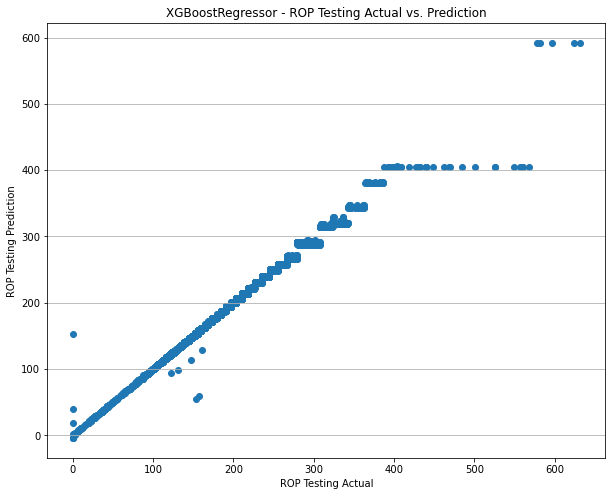

In [97]:
# Scaterplot ROP Testing Actual (y_blind) vs. Prediction (y_pred_blind)

plt.figure(figsize=(10,8))
plt.scatter(y_blind, y_pred_blind)
plt.xlabel('ROP Testing Actual')
plt.ylabel('ROP Testing Prediction')
plt.title('XGBoostRegressor - ROP Testing Actual vs. Prediction')
plt.grid(axis='y')
plt.show()

**XGBoost - Grafico de ROP (blind dataset)**

ROP Real (azul) vs. ROP predição (verde)

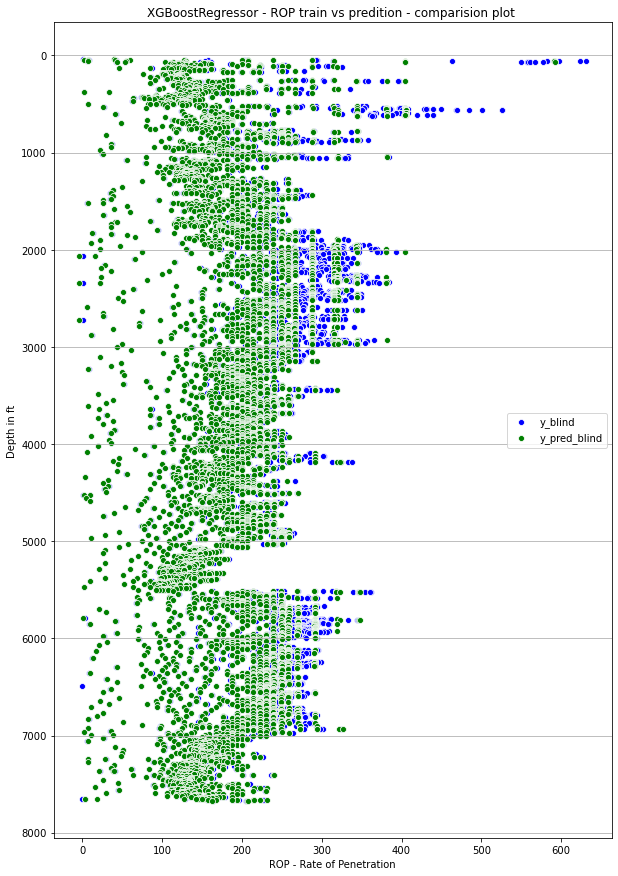

In [98]:
# ROP Blind vs. Preiction - Comparação

plt.figure(figsize=(10,15))
sns.scatterplot(x=y_blind, y=sw_cleaned['DEPT'], label='y_blind', color='blue')
sns.scatterplot(x=y_pred_blind, y=sw_cleaned['DEPT'], label='y_pred_blind', color='green')
#plt.xscale('log')
#plt.xscale('symlog')
plt.grid(axis='y')
plt.xlabel('ROP - Rate of Penetration')
plt.ylabel('Depth in ft')
plt.title('XGBoostRegressor - ROP train vs predition - comparision plot ')
plt.gca().invert_yaxis()
plt.legend(loc=7)
plt.show()